<a href="https://colab.research.google.com/github/AryanMethil/Speaker-Recognition/blob/main/Speaker_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import random

In [2]:
DATASET_FOLDER = '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/'

In [3]:
all_files = []
for folder, subfolder, files in os.walk(DATASET_FOLDER):
  if(folder != DATASET_FOLDER):
    all_files += [folder+'/'+f for f in files]

random.shuffle(all_files)
print(all_files)
print(len(all_files))

['/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Benjamin_Netanyau/18.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Benjamin_Netanyau/10.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Nelson_Mandela/0.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Julia_Gillard/5.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Magaret_Tarcher/5.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Julia_Gillard/6.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Julia_Gillard/3.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Nelson_Mandela/9.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/Magaret_Tarcher/2.wav', '/content/drive/MyDrive/Speak

In [4]:
# Inputs an audio file path and returns the transpose of the mfcc matrix

def get_mfcc_coeffs(audio_file_path):
  signal, sr = librosa.load(audio_file_path)
  mfcc = librosa.feature.mfcc(signal,n_mfcc=13,sr=sr)
  delta_mfcc=librosa.feature.delta(mfcc)
  delta_2_mfcc=librosa.feature.delta(mfcc,order=2)
  comprehensive_mfcc = np.concatenate((mfcc,delta_mfcc,delta_2_mfcc))
  return np.transpose(comprehensive_mfcc)

In [5]:
# Inputs the list of all audio file paths and outputs a feature matrix of shape (#pairs_possible, 2, #frames, #mfcc_coeffs + #delta_mfcc_coeffs + #delta_2_mfcc_coeffs) and a targets vector containining #pairs_possible elements

def create_feature_matrix(all_files):
  x=[]
  y=[]
  for pair in itertools.combinations(all_files,2):
    a,b = pair
    mfcc_a = get_mfcc_coeffs(a)
    mfcc_b = get_mfcc_coeffs(b)
    x.append([mfcc_a,mfcc_b])
    if(a[83:a.rfind(r"/")]==b[83:b.rfind(r"/")]):
      y.append(1)
    else:
      y.append(0)
  x = np.array(x)
  y = np.array(y)
  return x,y

In [6]:
x,y = create_feature_matrix(all_files)
print(x.shape)
print(y.shape)

(1225, 2, 44, 39)
(1225,)


In [7]:
def show_random_pair(x,y,show=False):
  if show:
    %matplotlib inline
    indices_0 = [i for i,x in enumerate(y) if x==0]
    indices_1 = [i for i,x in enumerate(y) if x==1]

    random_dissim_pair=random.choice(indices_0)
    random_sim_pair=random.choice(indices_1)

    for i,pair_no in enumerate((random_dissim_pair,random_sim_pair)):
      plt.figure(figsize=(20,10))
      plt.suptitle("Dissimilar" if i==0 else "Similar")
      plt.subplot(2,3,1)
      librosa.display.specshow(np.transpose(x[pair_no][0][:][:13]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,2)
      librosa.display.specshow(np.transpose(x[pair_no][0][:][13:26]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,3)
      librosa.display.specshow(np.transpose(x[pair_no][0][:][26:]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,4)
      librosa.display.specshow(np.transpose(x[pair_no][1][:][:13]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,5)
      librosa.display.specshow(np.transpose(x[pair_no][1][:][13:26]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,6)
      librosa.display.specshow(np.transpose(x[pair_no][1][:][26:]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      print('\n')
    plt.show()

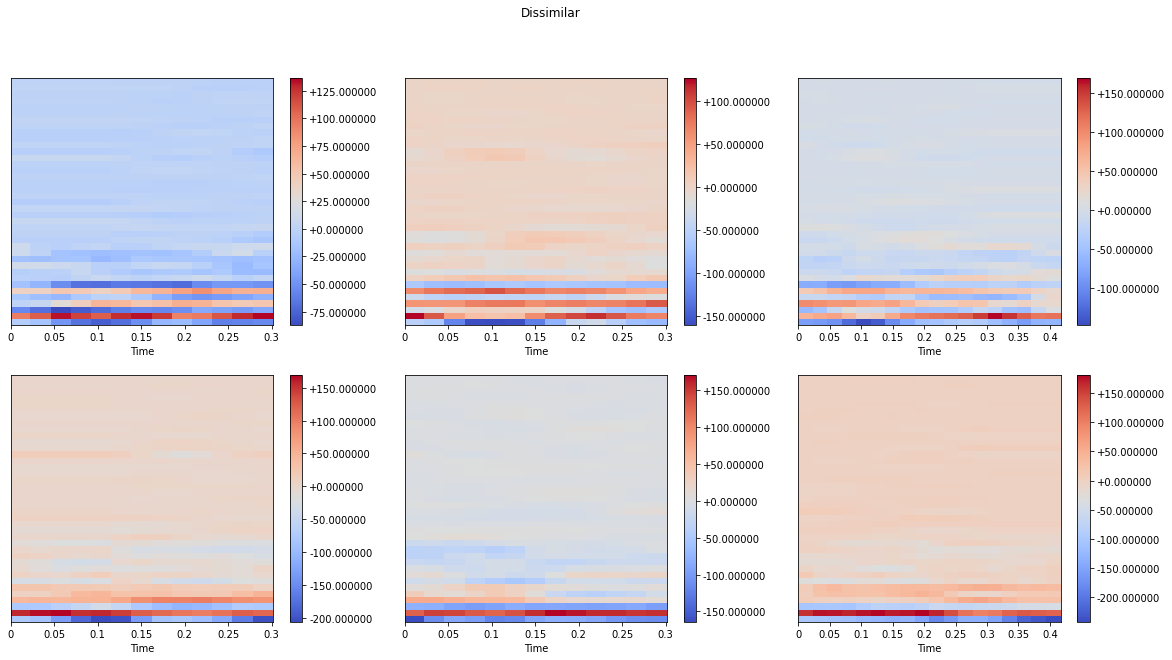

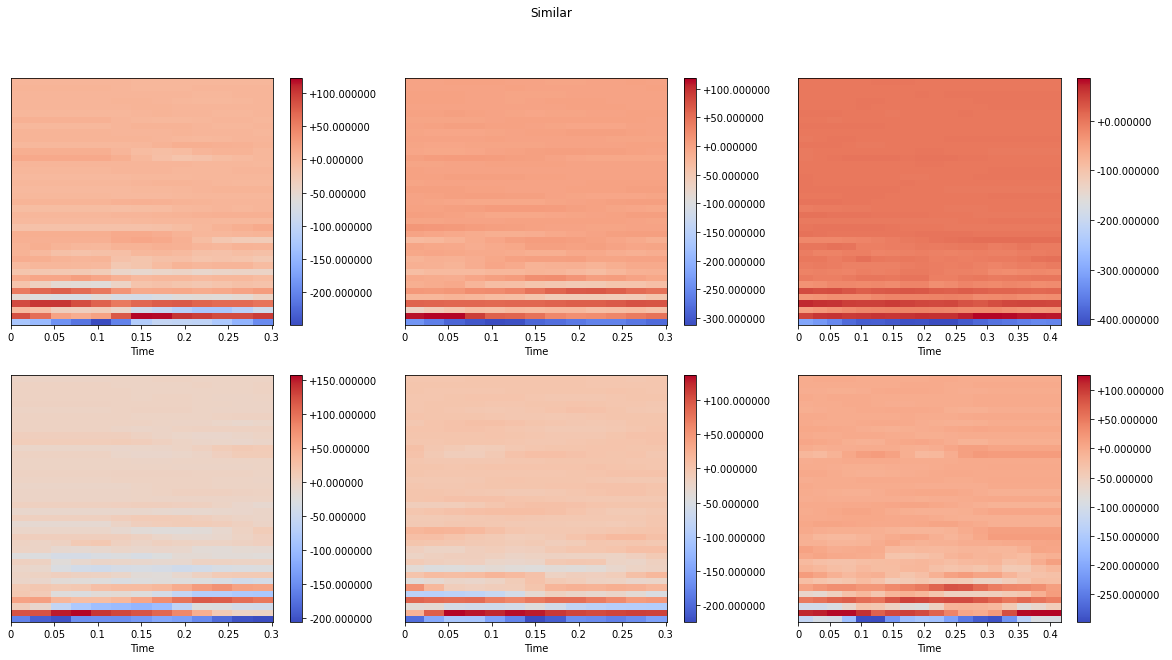

In [8]:
show_random_pair(x,y,show=True)

In [9]:
# Print the number class-wise unique values
print(np.unique(y,return_counts=True))

(array([0, 1]), array([1000,  225]))


In [10]:
!pip install tensorflow==2.2.0

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

print(tf.__version__)

2.2.0


In [12]:
def initialize_base_network():
    input = Input(shape=(44,39,), name="base_input")
    x = LSTM(128,return_sequences=True)(input)
    x = LSTM(64)(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.2)(x)

    return Model(inputs=input, outputs=x)


def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


In [13]:
base_network = initialize_base_network()

In [14]:
input_a = Input(shape=(44,39,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(44,39,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [15]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [16]:
margins = [0.1,0.2,0.5,1.0,1.5,2.0,2.5,3,3.5,4,4.5,5,6,7,8,9,10]
loss_wrt_margin = []
acc_wrt_margin = []
for margin in margins:
  print(f'Current Margin used for Contrastive loss : {margin}')
  model.compile(loss=contrastive_loss_with_margin(margin=margin), 
                optimizer=Adam(learning_rate=0.01),
                metrics=['accuracy'])
  history = model.fit([x[:,0], x[:,1]], y, epochs=20, batch_size=32, verbose=0)
  loss_wrt_margin.append(history.history['loss'][-1])
  acc_wrt_margin.append(history.history['accuracy'][-1])

Current Margin used for Contrastive loss : 0.1
Current Margin used for Contrastive loss : 0.2
Current Margin used for Contrastive loss : 0.5
Current Margin used for Contrastive loss : 1.0
Current Margin used for Contrastive loss : 1.5
Current Margin used for Contrastive loss : 2.0
Current Margin used for Contrastive loss : 2.5
Current Margin used for Contrastive loss : 3
Current Margin used for Contrastive loss : 3.5
Current Margin used for Contrastive loss : 4
Current Margin used for Contrastive loss : 4.5
Current Margin used for Contrastive loss : 5
Current Margin used for Contrastive loss : 6
Current Margin used for Contrastive loss : 7
Current Margin used for Contrastive loss : 8
Current Margin used for Contrastive loss : 9
Current Margin used for Contrastive loss : 10


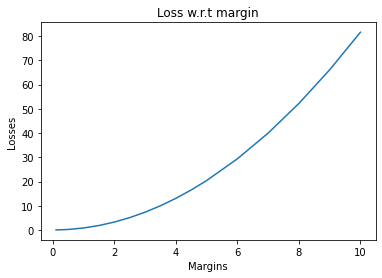

In [17]:
plt.plot(margins,loss_wrt_margin)
plt.title('Loss w.r.t margin')
plt.xlabel('Margins')
plt.ylabel('Losses')
plt.show()

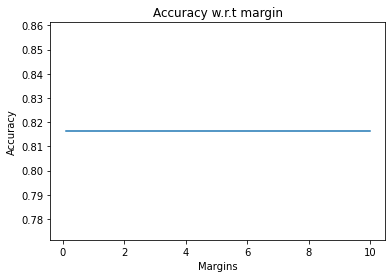

In [18]:
plt.plot(margins,acc_wrt_margin)
plt.title('Accuracy w.r.t margin')
plt.xlabel('Margins')
plt.ylabel('Accuracy')
plt.show()

In [19]:
model.compile(loss=contrastive_loss_with_margin(margin=0.1), 
                optimizer=Adam(learning_rate=0.01),
                metrics=['accuracy'])
history = model.fit([x[:,0], x[:,1]], y, epochs=20, batch_size=32, verbose=1,class_weight={0:1,1:4})

Epoch 1/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 2/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 3/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 4/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 5/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 6/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 7/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 8/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0125 - accuracy: 0.8163
Epoch 9/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0126 - accuracy: 0.8163
Epoch 10/20
39/39 [==============================] - 0s 12ms/step - loss: 0.0126 - accuracy: 0.8163
Epoch 11/